In [44]:
import torch
import torch.nn as nn
import torch.distributions as d
from torch.distributions.relaxed_categorical import ExpRelaxedCategorical, RelaxedOneHotCategorical
import matplotlib.pyplot as plt

## Exploration

`torch.distributions.relaxed_categorical.RelaxedOneHotCategorical(temperature, probs=None, logits=None, validate_args=None)`

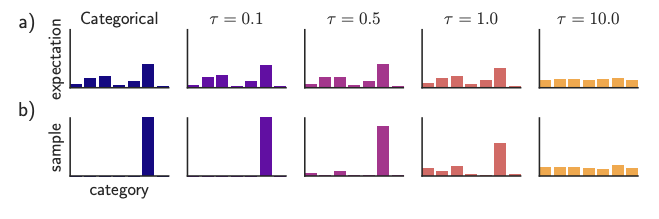

In [5]:
dist = RelaxedOneHotCategorical(torch.tensor([0.5]), probs=torch.tensor([0.1, 0.9, 0.3]))

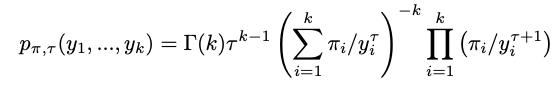

In [6]:
d.kl.kl_divergence(dist.base_dist._categorical, dist.base_dist._categorical)

tensor(0.)

In [7]:
from scipy.special import gamma
import numpy as np

In [8]:
# eq_prob = gamma(2) * 0.5 * (0.1 / sample_np[0] ** 0.5 + 0.9 / sample_np[1] ** 0.5) ** (-2) * (
#     (0.1 / sample_np[0] ** (0.5+1)) * (0.9 / sample_np[1] ** (0.5+1))
# )
# np.log(eq_prob)

In [9]:
samples = dist.sample(sample_shape=(100,))

In [10]:
dist.log_prob(samples)

tensor([-0.1658, -1.1185,  5.8295,  4.1610,  3.4732,  3.5512,  0.2392,  5.9985,
         3.0133, -1.4693,  4.5328,  9.2657,  0.7526,  4.0216,  6.6527,  3.6923,
         6.9832,  0.9182,  5.5426, 17.4735,  2.0057,  6.2279,  7.7322, 16.6995,
         6.0122,  0.6927,  7.1551,  4.1574,  4.0904,  7.8903,  3.7929,  6.2535,
         3.8214, -1.8716,  4.8171,  8.9468,  0.6869,  0.7035,  0.0767, 10.1361,
         0.1423,  6.3553,  3.9339,  0.1256, -0.0436,  0.7863, -0.3861,  4.0713,
         2.0552, 14.9350,  7.6826, 10.2802,  6.9901,  2.7299, -0.6435,  1.2922,
         4.6356,  0.7211,  2.2588, -0.9947,  1.6090,  2.6541,  4.0841, -0.1546,
        10.0819,  8.7797, 10.0996,  2.1574, 12.6193,  0.6223,  1.5166, 11.0451,
         1.3170,  9.6864,  2.1668,  2.8351,  9.9853,  7.7713,  3.2013,  0.2794,
         8.6719,  7.6068, -0.9186,  2.7644,  5.7063,  2.3249,  3.7973, -1.0084,
         3.0635, -0.7939,  7.7181,  6.2828,  8.0283,  0.8680,  0.7869, -1.4240,
         5.9268,  5.0274,  0.2166,  4.44

In [11]:
dist = d.Categorical(probs=torch.tensor([0.5, 0.5]))

In [12]:
samples = dist.sample(sample_shape=(10, ))
samples

tensor([0, 1, 0, 1, 0, 0, 1, 0, 0, 0])

In [13]:
dist.log_prob(samples)

tensor([-0.6931, -0.6931, -0.6931, -0.6931, -0.6931, -0.6931, -0.6931, -0.6931,
        -0.6931, -0.6931])

## Distributions

In [14]:
import torch.distributions as d

OneHotCat = d.OneHotCategorical
RelaxedOneHotCat = d.relaxed_categorical.RelaxedOneHotCategorical

Ind = d.Independent
Normal = d.Normal

CB = d.ContinuousBernoulli

## Generative model

### Module for p(y)

In [138]:
class p_y_class(nn.Module):
    
    def __init__(self, y_dim):
        super().__init__()
        self.y_dim = y_dim
        self.logits = torch.ones(y_dim)
        
    def forward(self, head):
        if head == "one_hot_categorical":
            return OneHotCat(logits=self.logits)
        elif head == "gumbel_softmax":
            return RelaxedOneHotCat(logits=self.logits, temperature=torch.tensor([0.5]))
        else:
            raise ValueError(f"{head} is not a valid value for head.")

### Module for p(z|y)

In [16]:
class p_z_given_y_class(nn.Module):
    
    def __init__(self, y_dim, z_dim):
        super().__init__()
        self.y_dim = y_dim
        self.z_dim = z_dim
        self.shared = nn.Sequential(
            nn.Linear(y_dim, 500),
            nn.ReLU(),
            nn.Linear(500, 500),
            nn.ReLU(),
        )
        self.mus = nn.Linear(500, z_dim)
        self.sigmas = nn.Sequential(
            nn.Linear(500, z_dim),
            nn.Softplus()
        )
        
    def forward(self, ys):
        temp = self.shared(ys)
        return Ind(Normal(self.mus(temp), self.sigmas(temp)), 1)

### Module for p(x|z)

In [17]:
class p_x_given_z_class(nn.Module):

    def __init__(self, x_dim, z_dim):
        super().__init__()
        self.x_dim = x_dim
        self.z_dim = z_dim
        self.lambdas = nn.Sequential(
            nn.Linear(z_dim, 500),
            nn.ReLU(),
            #nn.Dropout(0.1),
            nn.Linear(500, 500),
            nn.ReLU(),
            #nn.Dropout(0.1),
            nn.Linear(500, x_dim),
            nn.Sigmoid()
        )

    def forward(self, zs):
        return Ind(CB(self.lambdas(zs)), 1)

## Approximate posterior

### Module for q(y|x)

In [361]:
class q_y_given_x_class(nn.Module):
    
    def __init__(self, x_dim, y_dim):
        super().__init__()
        self.x_dim = x_dim
        self.y_dim = y_dim
        self.layers = nn.Sequential(
            nn.Linear(x_dim, 500),
            nn.ReLU(),
            #nn.Dropout(0.1),
            nn.Linear(500, 500),
            nn.ReLU(),
            #nn.Dropout(0.1),
            nn.Linear(500, y_dim)
        )
        
    def forward(self, xs, head):
        if head == "one_hot_categorical":
            return OneHotCat(logits=self.layers(xs))
        elif head == "gumbel_softmax":
            return RelaxedOneHotCat(logits=self.layers(xs), temperature=torch.tensor([0.5]))
        else:
            raise ValueError(f"{head} is not a valid value for head.")
            
    def sample_gumbel(self, shape, is_cuda=False, eps=1e-20):
        U = torch.rand(shape)
        if is_cuda:
            U = U.cuda()
        return -torch.log(-torch.log(U + eps) + eps)
    
    def gumbel_softmax_sample(self, logits, temperature):
        y = logits + self.sample_gumbel(logits.size(), logits.is_cuda)
        return torch.nn.functional.softmax(y / temperature, dim=-1)
    
    def rsample(self, xs, temperature=0.5):
        """
        ST-gumple-softmax
        input: [*, n_class]
        return: flatten --> [*, n_class] an one-hot vector
        """
        logits = self.layers(xs)
        y = self.gumbel_softmax_sample(logits, temperature)
        return y

### Module for q(z|x, y)

In [364]:
class q_z_given_x_y_class(nn.Module):

    def __init__(self, x_dim, y_dim, z_dim):
        super().__init__()
        self.z_dim = z_dim
        self.x_dim = x_dim
        self.shared = nn.Sequential(
            nn.Linear(x_dim + y_dim, 500),
            nn.ReLU(),
            #nn.Dropout(0.1),
            nn.Linear(500, 500),
            nn.ReLU(),
            #nn.Dropout(0.1)
        )
        self.mus = nn.Linear(500, z_dim)
        self.sigmas = nn.Sequential(
            nn.Linear(500, z_dim),
            nn.Softplus()
        )

    def forward(self, xs, ys):
        temp = self.shared(torch.cat([xs, ys], dim=1))
        return Ind(Normal(self.mus(temp), self.sigmas(temp)), 1)

## AEVB

In [365]:
import itertools
import torch.optim as optim

In [572]:
q_y_given_x = q_y_given_x_class(x_dim=28*28, y_dim=10)
q_y_given_x(torch.randn(32, 28*28), head="one_hot_categorical").mean.shape

torch.Size([32, 10])

In [584]:
a = torch.stack([
    d.kl.kl_divergence(post_over_zs, self.p_z_given_y(torch.eye(10)[y].unsqueeze(0))) 
    for y in range(10)
]).T

stuff = []
for y in range(10):
    ys = torch.eye(10)[y].unsqueeze(0).repeat(bs, 1)
    zs = self.q_z_given_x_y(xs, ys).rsample()
    fs = self.p_x_given_z(zs).log_prob(xs) \
         + self.p_z_given_y(ys).log_prob(zs) \
         + self.p_y().log_prob(ys) \
         - self.q_z_given_x_y(xs, ys).log_prob(zs) \
         - self.q_y_given_x(xs).log_prob(ys)
stuff = torch.stack(stuff).T

NameError: name 'post_over_zs' is not defined

In [578]:
q_z_given_x_y = q_z_given_x_y_class(z_dim=20, x_dim=28*28, y_dim=10)

In [653]:
torch.eye(10)

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])

In [759]:
torch.eye(10)[torch.tensor(range(10)).repeat(3)]

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],


In [794]:
a = torch.tensor([
    [1, 2, 3],
    [4, 5, 6]
])

In [795]:
a.repeat(3, 1)

tensor([[1, 2, 3],
        [4, 5, 6],
        [1, 2, 3],
        [4, 5, 6],
        [1, 2, 3],
        [4, 5, 6]])

In [1317]:
class AEVB():
    
    def __init__(self, x_dim, y_dim, z_dim, lr=1e-3):
        
        super().__init__()
        
        self.x_dim = x_dim
        self.y_dim = y_dim
        self.z_dim = z_dim
        
        # generative model
        
        self.p_y = p_y_class(y_dim)
        self.p_z_given_y = p_z_given_y_class(y_dim, z_dim)
        self.p_x_given_z = p_x_given_z_class(x_dim, z_dim)

        # approximate posterior
        
        self.q_y_given_x = q_y_given_x_class(x_dim, y_dim)
        self.q_z_given_x_y = q_z_given_x_y_class(x_dim, y_dim, z_dim)
        
        # optimizers
        
        self.opt = optim.Adam(
            itertools.chain(
                self.p_z_given_y.parameters(),
                self.p_x_given_z.parameters(),
                self.q_y_given_x.parameters(),
                self.q_z_given_x_y.parameters()
            ), 
            lr=lr
        )
        
    def step(self, xs, train):
        
#         ys = self.q_y_given_x.rsample(xs)
#         post_over_zs = self.q_z_given_x_y(xs, ys)
#         zs = post_over_zs.rsample()
        
#         post_over_ys_hard = self.q_y_given_x(xs, head="one_hot_categorical")

#         fs = self.p_x_given_z(zs).log_prob(xs) \
#              - d.kl.kl_divergence(post_over_ys_hard, self.p_y(head="one_hot_categorical")) \
#              - d.kl.kl_divergence(post_over_zs, self.p_z_given_y(ys))
            
#         a = torch.stack([
#              d.kl.kl_divergence(post_over_zs, self.p_z_given_y(torch.eye(10)[y].unsqueeze(0))) for y in range(10)
#         ]).T

#         - (post_over_ys_hard.mean * a).sum(dim=1)
# 
#         post_over_ys = self.q_y_given_x(xs, head="gumbel_softmax")
#         ys = post_over_ys.rsample()
#         post_over_zs = self.q_z_given_x_y(xs, ys)
#         zs = post_over_zs.rsample()
    
#         fs = self.p_x_given_z(zs).log_prob(xs) \
#            + self.p_z_given_y(ys).log_prob(zs) \
#            + self.p_y(head="gumbel_softmax").log_prob(ys) \
#            - post_over_ys.log_prob(ys) \
#            - post_over_zs.log_prob(zs)

#         ys = torch.eye(10)[y].unsqueeze(0).repeat(xs.size(0), 1)
#         zs = self.q_z_given_x_y(xs, ys).rsample()
#         fs = self.p_x_given_z(zs).log_prob(xs) \
#              + self.p_y(head="one_hot_categorical").log_prob(ys) \
#              - self.q_y_given_x(xs, head="one_hot_categorical").log_prob(ys) \
#              - d.kl.kl_divergence(self.q_z_given_x_y(xs, ys), self.p_z_given_y(ys))
#         stuff.append(fs)
#         stuff = torch.stack(stuff).T

        probs = self.q_y_given_x(xs, head="one_hot_categorical").mean

        bs = xs.size(0)
    
        ys = torch.eye(self.y_dim)[torch.tensor(range(self.y_dim)).repeat_interleave(bs)]
        xs = xs.repeat(self.y_dim, 1)
        post_over_zs = self.q_z_given_x_y(xs, ys)
        zs = post_over_zs.rsample()
        fs = self.p_x_given_z(zs).log_prob(xs) \
             + self.p_y(head="one_hot_categorical").log_prob(ys) \
             - self.q_y_given_x(xs, head="one_hot_categorical").log_prob(ys) \
             - d.kl.kl_divergence(post_over_zs, self.p_z_given_y(ys))
        fs = fs.reshape(bs, self.y_dim)
        fs = (probs * fs).sum(dim=1)
        
        estimated_elbo = fs.mean()
        loss = - estimated_elbo
        
        if train:
            self.opt.zero_grad()
            loss.backward()
            self.opt.step()
        
        return float(estimated_elbo)
    
    def predict_cluster(self, xs):
        with torch.no_grad():
            return self.q_y_given_x(xs, head="one_hot_categorical").mean.argmax(dim=1)
    
    def generate(self, n, mode):
        with torch.no_grad():
            ys = self.p_y(head="one_hot_categorical").sample((n, ))
            zs = self.p_z_given_y(ys).sample()
            if mode == "mean":
                xs = self.p_x_given_z(zs).mean
            elif mode == "sample":
                xs = self.p_x_given_z(zs).sample()
            elif mode == "param":
                xs = self.p_x_given_z.lambdas(zs)
            return xs
    
    def generate_from_cluster(self, n, cluster_index, mode):
        with torch.no_grad():
            ys = torch.eye(self.y_dim)[cluster_index].repeat(n, 1)
            zs = self.p_z_given_y(ys).sample()
            if mode == "mean":
                xs = self.p_x_given_z(zs).mean
            elif mode == "sample":
                xs = self.p_x_given_z(zs).sample()
            elif mode == "param":
                xs = self.p_x_given_z.lambdas(zs)
            return xs
    
#     def save(self):
#         torch.save(self.state_dict(), "gmvae.pth")

#     def load(self):
#         self.load_state_dict(torch.load("gmvae.pth", map_location=torch.device("cpu")))

In [1391]:
aevb = AEVB(x_dim=28*28, y_dim=10, z_dim=64)

In [1392]:
data = 0.99 * torch.randn(5, 28*28).clip(0, 1)

In [1521]:
aevb.step(data, train=True)

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], grad_fn=<SoftmaxBackward0>)
tensor([[ 0.1808, -0.2746,  1.7047,  ...,  0.7113, -1.0240,  0.1849],
        [ 0.2799,  2.2017, -0.4248,  ...,  1.6380, -1.5244, -2.1101],
        [-1.1031, -0.2939, -1.7693,  ..., -1.8055,  0.9438,  1.1101],
        ...,
        [-2.2528,  1.4287,  0.3615,  ...,  0.9329, -0.4076, -0.8329],
        [-0.1840,  0.2710, -0.3585,  ..., -1.2185, -3.0774, -2.2099],
        [-1.0325,  1.9154, -1.7294,  ..., -0.4463, -4.1312,  1.3015]],
       grad_fn=<AddBackward0>)
torch.Size([5])


238106.125

## Data

In [779]:
import numpy as np
from keras.datasets.mnist import load_data
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

In [851]:
(x_train, y_train), (x_test, y_test) = load_data()

x_train = x_train + np.random.uniform(low=0, high=1, size=x_train.shape)
x_train = x_train / 256
x_train = x_train.reshape(-1, 28*28)

x_test = x_test + np.random.uniform(low=0, high=1, size=x_test.shape)
x_test = x_test / 256
x_test = x_test.reshape(-1, 28*28)

train_ds = TensorDataset(torch.from_numpy(x_train).float())
train_dl = DataLoader(train_ds, batch_size=64)

test_ds = TensorDataset(torch.from_numpy(x_test).float(), torch.from_numpy(y_test).long())
test_dl = DataLoader(test_ds, batch_size=1000, shuffle=False)

(array([5923., 6742., 5958., 6131., 5842., 5421., 5918., 6265., 5851.,
        5949.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <BarContainer object of 10 artists>)

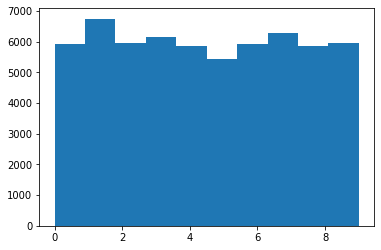

In [852]:
plt.hist(y_train)

In [853]:
y_test[99]

9

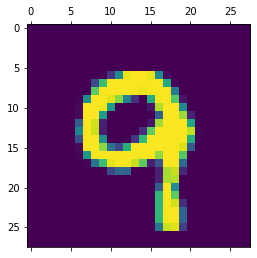

In [854]:
plt.matshow(x_test[99].reshape(28, 28))
plt.show()

## Training

In [855]:
from scipy.optimize import linear_sum_assignment
def cluster_acc(Y_pred, Y):
    Y_pred, Y = np.array(Y_pred), np.array(Y)
    assert Y_pred.size == Y.size
    D = max(Y_pred.max(), Y.max())+1
    w = np.zeros((D,D), dtype=np.int64)
    for i in range(Y_pred.size):
        w[Y_pred[i], Y[i]] += 1
    row, col = linear_sum_assignment(w.max()-w)
    return sum([w[row[i],col[i]] for i in range(row.shape[0])]) * 1.0/Y_pred.size

In [856]:
cluster_acc(np.array([1, 2, 3]), np.array([3, 2, 1]))

1.0

In [857]:
x_test_torch = torch.from_numpy(x_test).float()

In [858]:
from tqdm import tqdm

In [859]:
torch.manual_seed(42)

aevb = AEVB(x_dim=28*28, y_dim=10, z_dim=64)

test_elbos = []

for epoch in range(100):
    
    print(epoch)
    
    for (xb, ) in tqdm(train_dl):
        aevb.step(xb, train=True)
    
    test_elbo = aevb.step(x_test_torch, train=False)
    test_acc = cluster_acc(aevb.predict_cluster(x_test_torch).numpy(), y_test)
    
    print(test_elbo, test_acc)

aevb.save()
    
with open("test_elbos", "wb") as fp:
    pickle.dump(test_elbos, fp)

0


100%|█████████████████████████████████████████| 938/938 [00:39<00:00, 23.51it/s]


107188256.0 0.1135
1


 13%|█████▏                                   | 119/938 [00:04<00:34, 23.93it/s]


KeyboardInterrupt: 

## Reconstruction

In [648]:
import matplotlib.pyplot as plt

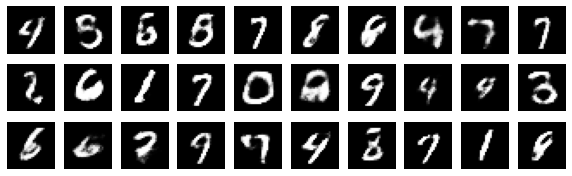

In [649]:
torch.manual_seed(10)
gens = aevb.generate(n=30, mode="param").detach()
plt.figure(figsize=(10, 3))
for i in range(1, 31):
    plt.subplot(3, 10, i)
    plt.imshow(gens[i-1].reshape(28, 28), cmap='gray')
    plt.axis('off')
plt.show()
    #plt.savefig("vae_mnist_gens_param.pdf", bbox_inches='tight',pad_inches = 0)

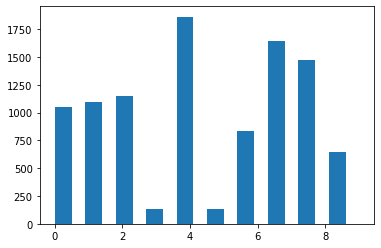

In [650]:
plt.hist(aevb.predict_cluster(x_test_torch).numpy(), width=0.5)
plt.show()

## Generation per category

In [651]:
def generate_from_cluster(self, n, cluster_index, mode):
    with torch.no_grad():
        ys = torch.eye(self.y_dim)[cluster_index].repeat(n, 1)
        zs = self.p_z_given_y(ys).sample()
        if mode == "mean":
            xs = self.p_x_given_z(zs).mean
        elif mode == "sample":
            xs = self.p_x_given_z(zs).sample()
        elif mode == "param":
            xs = self.p_x_given_z.lambdas(zs)
        return xs

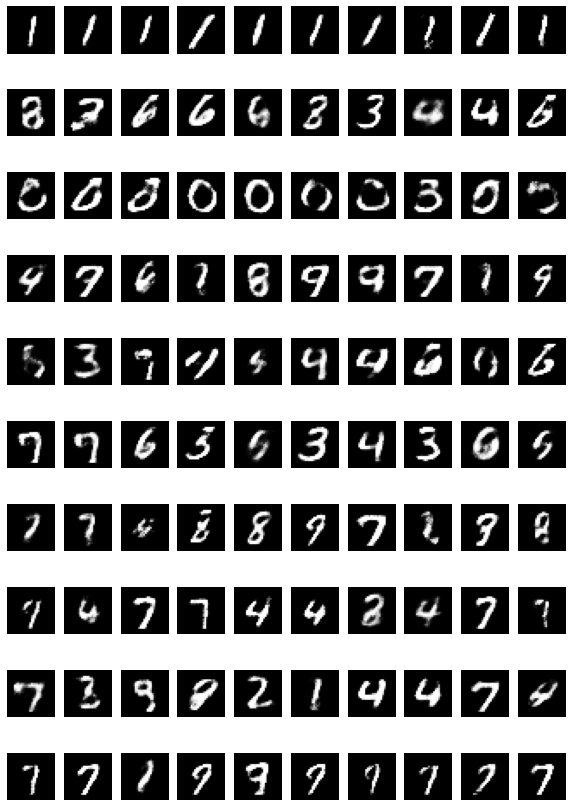

In [652]:
torch.manual_seed(42)
plt.figure(figsize=(10, 15))
for row_index in range(10):
    gens = generate_from_cluster(aevb, n=10, cluster_index=row_index, mode="param").detach()
    for col_index in range(10):
        plt.subplot(10, 10, row_index * 10 + col_index + 1)
        plt.imshow(gens[col_index].reshape(28, 28), cmap='gray')
        plt.axis('off')
plt.show()
    #plt.savefig("vae_mnist_gens_param.pdf", bbox_inches='tight',pad_inches = 0)